In [59]:
import pandas as pd
from pathlib import Path
import re
import numpy as np

# ESM imports
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig, ESMProteinTensor
from esm.models.esmc import _BatchedESMProteinTensor

# Tokenizer imports
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders

# PEFT imports
from peft import get_peft_model, LoraConfig, TaskType
from peft.tuners.lora import LoraConfig, LoraModel

In [60]:
# Things to define in new notebook to import so I can load the models effectively
# class ESMFactorisedEncoder(nn.Module):
# Step 0 — Prereqs:
# tcr_encoder loaded and on GPU (or CPU if tiny)
# factoriser loaded and on GPU

# clono_global dataframe with column sequence_aa (beta chain)

# Also: the same tokenisation method you used previously that produced:
# clean_input_ids
# attention_mask
# because we used these exact keys in the old code

# tcr_loader: DataLoader yielding dicts with those keys



In [61]:
BASE_DIR  = Path("/home/natasha/multimodal_model") #/ "data" / "raw"
DATA_DIR = BASE_DIR / "data" / "ICR" / "data_2025_renamed"

In [62]:
# DATA_DIR should point to the folder containing the .tsv.gz files
# e.g. DATA_DIR = Path("/home/natasha/multimodal_model/data/raw/ICR/data_2025_renamed")

FNAME_RE = re.compile(
    r"^(?P<subject>ES\d+)_"
    r"(?P<timepoint>T\d+)_"
    r"(?P<tissue>[A-Za-z]+)_"
    r"(?P<library>C\d+)$"
)

def parse_sample_id(stem: str) -> dict:
    """
    Parse e.g. 'ES01_T1_Bo_C3' into metadata fields.
    Falls back gracefully if a file doesn't match.
    """
    m = FNAME_RE.match(stem)
    if not m:
        return {
            "sample_id": stem,
            "subject_id": None,
            "timepoint": None,
            "tissue": None,
            "library": None,
            "fname_parse_ok": False,
        }
    d = m.groupdict()
    return {
        "sample_id": stem,
        "subject_id": d["subject"],
        "timepoint": d["timepoint"],
        "tissue": d["tissue"],
        "library": d["library"],
        "fname_parse_ok": True,
    }

dfs = []
files = sorted(DATA_DIR.glob("*.tsv.gz"))

for fp in files:
    stem = fp.name.replace(".tsv.gz", "")
    meta = parse_sample_id(stem)

    df = pd.read_csv(fp, sep="\t", compression="gzip")
    for k, v in meta.items():
        df[k] = v

    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

print("Files:", len(files))
print("Rows:", len(full_df))
print("Filename parse OK:", full_df["fname_parse_ok"].mean())
full_df.head()


Files: 152
Rows: 191764
Filename parse OK: 0.5565695333847854


,sequence_id,v_call,d_call,j_call,junction_aa,duplicate_count,sequence,junction,decombinator_id,rev_comp,...,v_cigar,d_cigar,j_cigar,av_UMI_cluster_size,sample_id,subject_id,timepoint,tissue,library,fname_parse_ok
0,1,TRBV20-1,NaN,TRBJ2-1,CSAHGQQGNLYNEQFF,28,GGTGCTGTCGTCTCTCAACATCCGAGCTGGGTTATCTGTAAGAGTG...,TGCAGTGCGCATGGACAGCAGGGCAACCTATACAATGAGCAGTTCTTC,"15, 6, 6, 4, GCATGGACAGCAGGGCAACCTA",F,...,NaN,NaN,NaN,18,ES01_T1_Bo_C3,ES01,T1,Bo,C3,True
1,2,TRBV20-1,NaN,TRBJ1-2,CSASSHHQLLTNYGYTF,20,GGTGCTGTCGTCTCTCAACATCCGAGCTGGGTTATCTGTAAGAGTG...,TGCAGTGCTAGCTCACACCACCAGTTACTAACTAACTATGGCTACA...,"15, 1, 3, 0, CTCACACCACCAGTTACTAA",F,...,NaN,NaN,NaN,20,ES01_T1_Bo_C3,ES01,T1,Bo,C3,True
2,3,TRBV5-5,NaN,TRBJ1-2,CASSPTGSNYGYTF,6,GACGCTGGAGTCACCCAAAGTCCCACACACCTGATCAAAACGAGAG...,TGTGCCAGCAGTCCTACAGGGTCTAACTATGGCTACACCTTC,"28, 1, 5, 0, TCCTACAGGGT",F,...,NaN,NaN,NaN,25,ES01_T1_Bo_C3,ES01,T1,Bo,C3,True
3,4,TRBV7-9,NaN,TRBJ2-1,NaN,2,GATACTGGAGTCTCCCAGAACCCCAGACACAAGATCACAAAGAGGG...,NaN,"43, 6, 5, 1, CCCTAGGACCTGGGGGA",F,...,NaN,NaN,NaN,14,ES01_T1_Bo_C3,ES01,T1,Bo,C3,True
4,5,TRBV20-1,NaN,TRBJ2-1,CSARKLVELNEQFF,14,GGTGCTGTCGTCTCTCAACATCCGAGCTGGGTTATCTGTAAGAGTG...,TGCAGTGCTAGGAAGCTAGTGGAACTCAATGAGCAGTTCTTC,"15, 6, 3, 6, GAAGCTAGTGGAACT",F,...,NaN,NaN,NaN,19,ES01_T1_Bo_C3,ES01,T1,Bo,C3,True


In [63]:
def coerce_bool(s: pd.Series) -> pd.Series:
    """
    Robust coercion for AIRR-ish boolean columns which may be:
    True/False, "T"/"F", "true"/"false", "1"/"0", 1/0, or missing.
    Returns pandas BooleanDtype (allows <NA>).
    """
    if s.dtype == "bool":
        return s.astype("boolean")

    x = s.astype(str).str.strip().str.lower()

    true_vals  = {"true", "t", "1", "yes", "y"}
    false_vals = {"false", "f", "0", "no", "n"}

    out = pd.Series(pd.NA, index=s.index, dtype="boolean")
    out[x.isin(true_vals)] = True
    out[x.isin(false_vals)] = False

    # also handle actual numeric 0/1 if they were cast to "0.0"/"1.0"
    out[x.isin({"1.0"})] = True
    out[x.isin({"0.0"})] = False

    return out

# Apply
if "productive" in full_df.columns:
    full_df["productive"] = coerce_bool(full_df["productive"])

# Optional: sanity
full_df["productive"].value_counts(dropna=False).head(10)

productive
True     156585
False     35179
Name: count, dtype: Int64

In [64]:
# Ensure keys look sane
full_df[["sample_id","subject_id","timepoint","tissue","library","fname_parse_ok"]].drop_duplicates().head(20)

# How many samples per subject?
full_df[["subject_id","sample_id"]].drop_duplicates().groupby("subject_id").size().sort_values(ascending=False).head(20)

# Productive rate by sample (often a good pipeline sanity check)
(full_df
 .groupby("sample_id")["productive"]
 .mean()
 .sort_values(ascending=False)
 .head(20)
)


sample_id
ES14_T1_Bo_C2    0.975904
ES05_T4_Li_N1    0.957692
ES21_T1_Bo_C1    0.948718
ES14_T5_Lu_C2     0.91924
ES19_T2_Lu_C4    0.914966
ES05_T4_Li_C1    0.912195
ES14_T6_Lu_N1    0.896254
ES15_T1_Bo_C1    0.893162
ES22_T3_Br_C1    0.890909
ES02_T1_LN_N2     0.88765
ES10_T1_Bo_C2    0.886792
ES10_T7_Me_C3    0.882353
ES21_T2_Bo_C3     0.88178
ES22_T1_Bo_C2    0.879736
ES01_T2_Lu_C1    0.878947
ES14_T6_Lu_C4    0.874172
ES19_T1_Li_C4    0.873874
ES15_T4_Lu_C1    0.871429
ES22_T1_Bo_C4    0.869198
ES22_T1_Bo_C1    0.865169
Name: productive, dtype: Float64

In [65]:
# only beta chains
full_df["v_call"].astype(str).str.extract(r"^(TR[AB]V)").value_counts(dropna=False).head(10)


0   
TRBV    191764
Name: count, dtype: int64

In [66]:
# only beta chains so add a column to explicitly state this
full_df["chain"] = "TRB"


In [67]:
# checl length of CDR3s
full_df["cdr3_len"] = full_df["sequence_aa"].str.len()

full_df["cdr3_len"].describe()



count    191764.000000
mean        114.110120
std           2.038267
min          96.000000
25%         113.000000
50%         114.000000
75%         115.000000
max         128.000000
Name: cdr3_len, dtype: float64

In [68]:
full_df.to_csv("icr_data_full.csv", index=False)

Clustering Analysis

In [69]:
# Filter to productive, clean TCR beta sequences

df = full_df.copy()

# keep only productive rearrangements
if "productive" in df.columns:
    df = df[df["productive"] == True].copy()

# drop missing / malformed CDR3s
df = df[df["sequence_aa"].notna()].copy()
df["sequence_aa"] = df["sequence_aa"].astype(str).str.strip()


# Optional sanity: restrict to valid AA alphabet
aa_re = r"^[ACDEFGHIKLMNPQRSTVWY]+$"
df = df[df["sequence_aa"].str.fullmatch(aa_re)].copy()

df.shape


(156585, 32)

In [70]:
# sample level clonotype - how expanded is each clonotype within each biological sample?

clono_sample = (
    df.groupby(["sample_id", "sequence_aa"], as_index=False)
      .agg(
          total_count=("duplicate_count", "sum"),
          n_rows=("duplicate_count", "size"),
          v_mode=("v_call", lambda x: x.value_counts().index[0] if x.notna().any() else None),
          j_mode=("j_call", lambda x: x.value_counts().index[0] if x.notna().any() else None),
      )
)

clono_sample["log_total_count"] = np.log1p(clono_sample["total_count"])

clono_sample.head()

,sample_id,sequence_aa,total_count,n_rows,v_mode,j_mode,log_total_count
0,ES01_T1_Bo_C3,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,6,1,TRBV13,TRBJ1-1,1.945910
1,ES01_T1_Bo_C3,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,3,1,TRBV13,TRBJ1-1,1.386294
2,ES01_T1_Bo_C3,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,7,1,TRBV13,TRBJ2-3,2.079442
3,ES01_T1_Bo_C3,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,1,1,TRBV13,TRBJ1-4,0.693147
4,ES01_T1_Bo_C3,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,9,1,TRBV13,TRBJ2-1,2.302585


In [71]:
# Global clonotype - how abundant and how shared is each clonotype across the dataset?

clono_global = (
    clono_sample.groupby("sequence_aa", as_index=False)
      .agg(
          total_count_all=("total_count", "sum"),
          n_samples=("sample_id", "nunique"),
          n_rows_all=("n_rows", "sum"),
      )
)

clono_global["log_total_count_all"] = np.log1p(clono_global["total_count_all"])
clono_global.head()

,sequence_aa,total_count_all,n_samples,n_rows_all,log_total_count_all
0,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,1,1,1,0.693147
1,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,1,1,1,0.693147
2,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,2,1,1,1.098612
3,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,1,1,1,0.693147
4,AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...,3,1,1,1.386294


In [72]:
print("Unique clonotypes:", len(clono_global))
print("Median samples per clonotype:", clono_global["n_samples"].median())
print("Top public clonotypes:")
clono_global.sort_values("n_samples", ascending=False).head(10)


Unique clonotypes: 133936
Median samples per clonotype: 1.0
Top public clonotypes:


,sequence_aa,total_count_all,n_samples,n_rows_all,log_total_count_all
62200,GAGVSQSPRYKVAKRGQDVALRCDPISGHVSLFWYQQALGQGPEFL...,833,23,34,6.726233
2409,DAGITQSPRHKVTETGTPVTLRCHQTENHRYMYWYRQDPGHGLRLI...,5493,23,65,8.611412
54193,EAQVTQNPRYLITVTGKKLTVTCSQNMNHEYMSWYRQDPGLGLRQI...,377,21,24,5.934894
5251,DAGITQSPRHKVTETGTPVTLRCHQTENHRYMYWYRQDPGHGLRLI...,3856,20,61,8.257645
72487,GAGVSQSPSNKVTEKGKDVELRCDPISGHTALYWYRQSLGQGLEFL...,327,20,23,5.793014
14569,DAGVTQSPTHLIKTRGQQVTLRCSPISGHKSVSWYQQVLGQGPQFI...,816,20,30,6.705639
59364,ETGVTQSPTHLIKTRGQQVTLRCSSQSGHNTVSWYQQALGQGPQFI...,416,20,25,6.033086
50455,EAGVTQFPSHSVIEKGQTVTLRCDPISGHDNLYWYRRVMGKEIKFL...,328,19,23,5.796058
127677,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGLQL...,279,18,22,5.634790
38577,DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...,111,18,18,4.718499


In [73]:
# took a log because normally things are very heavy tailed, but the highest value here seems to be like 23

ESM and Encoder Embedding Analysis

In [105]:
# Take a subset of the data to run analyses and plot

# fixed seed for reproducibility
seed = 42
rng = np.random.default_rng(seed)

N = len(clono_global)
n_plot = min(20000, N)   # 20k is a good default
idx = rng.choice(N, size=n_plot, replace=False)

# subset the dataframe once
clono_subset = clono_global.iloc[idx].reset_index(drop=True)


In [106]:
from torch.utils.data import Dataset, DataLoader
import torch


# ESM imports
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig, ESMProteinTensor
from esm.models.esmc import _BatchedESMProteinTensor


# visuals
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [107]:
# Example: Create a simple dataset object for the 'sequence_aa' column from clono_global

class SequenceAADataset(Dataset):
    """Dataset for sequence AA data"""
    def __init__(self, data, column_name='sequence_aa'):
        self.data = data
        self.column_name = column_name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sequence_aa = row[self.column_name]
        return sequence_aa


In [108]:
tcr = SequenceAADataset(data=clono_subset, column_name='sequence_aa')
#tcr = SequenceAADataset(data=clono_global, column_name='sequence_aa')
tcrs = [ESMProtein(sequence=s) for s in tcr.data['sequence_aa']]


In [109]:
model = ESMC.from_pretrained("esmc_300m").eval()
tcrs_data = [seq for seq in tcr]
encoded_tcrs = [model.encode(p) for p in tcrs]



In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

pad_id = model.tokenizer.pad_token_id
print("pad_id:", pad_id)

def pad_batch_1d(token_seqs, pad_id: int):
    lengths = torch.tensor([t.numel() for t in token_seqs], device=device)
    max_len = int(lengths.max().item())
    out = torch.full((len(token_seqs), max_len), pad_id, dtype=token_seqs[0].dtype, device=device)
    for i, t in enumerate(token_seqs):
        out[i, : t.numel()] = t
    attn = (out != pad_id)  # True on real tokens
    return out, attn, lengths


pad_id: 1


In [111]:
@torch.no_grad()
def embed_esmc_from_encoded(encoded_list, batch_size=16, use_amp=True):
    all_vecs = []
    for i in range(0, len(encoded_list), batch_size):
        batch = encoded_list[i:i+batch_size]

        token_seqs = [pt.sequence.to(device) for pt in batch]  # ESMProteinTensor.sequence
        toks, attn, lengths = pad_batch_1d(token_seqs, pad_id)

        # Optional explicit mask if ESMC supports it
        # sequence_id = attn  # boolean mask where non-pad
        # out = model(toks, sequence_id=sequence_id)

        if use_amp and device.type == "cuda":
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                out = model(toks)
        else:
            out = model(toks)

        # out.embeddings is [B, L, D]
        hidden = out.embeddings

        # Mean-pool over non-pad tokens
        mask = attn.float()
        vec = (hidden * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True).clamp_min(1.0)

        all_vecs.append(vec.detach().cpu().numpy())

        # free GPU memory each batch
        del toks, attn, lengths, out, hidden, mask, vec
        if device.type == "cuda":
            torch.cuda.empty_cache()

    return np.concatenate(all_vecs, axis=0)


In [112]:
X = embed_esmc_from_encoded(encoded_tcrs, batch_size=8, use_amp=True)
print("X:", X.shape)


X: (20000, 960)


T-SNE Plots

In [113]:
# subsample the data to 20K rather than the full 130K
# already subsamled to 20K so it's consistent throughout for plotting purposes

N = X.shape[0]
#rng = np.random.default_rng(42)

#n_plot = min(20000, N)   # 20k is a good default
#idx = rng.choice(N, size=n_plot, replace=False)

#X_sub = X[idx]

X_sub = X
print(X_sub.shape)



(20000, 960)


In [114]:
X_pca = PCA(n_components=50, random_state=42).fit_transform(X_sub)
print(X_pca.shape)


(20000, 50)


In [115]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    random_state=42
)

Z = tsne.fit_transform(X_pca)
print(Z.shape)


(20000, 2)


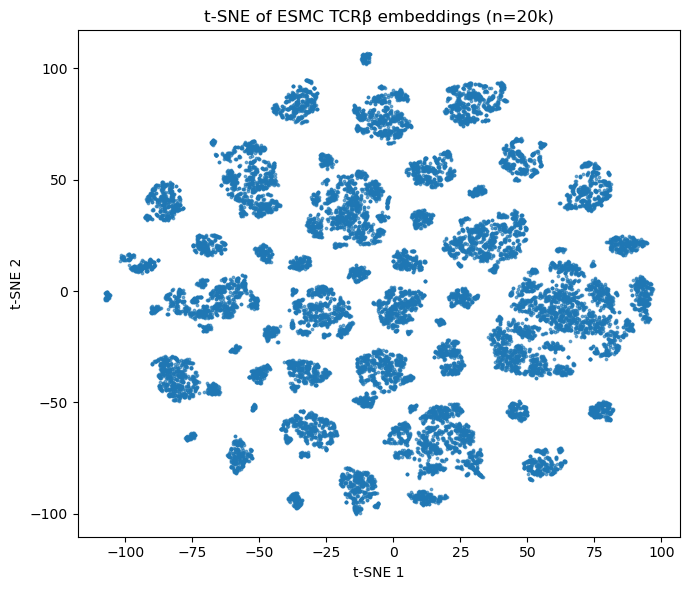

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(Z[:,0], Z[:,1], s=3, alpha=0.6)
plt.title("t-SNE of ESMC TCRβ embeddings (n=20k)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


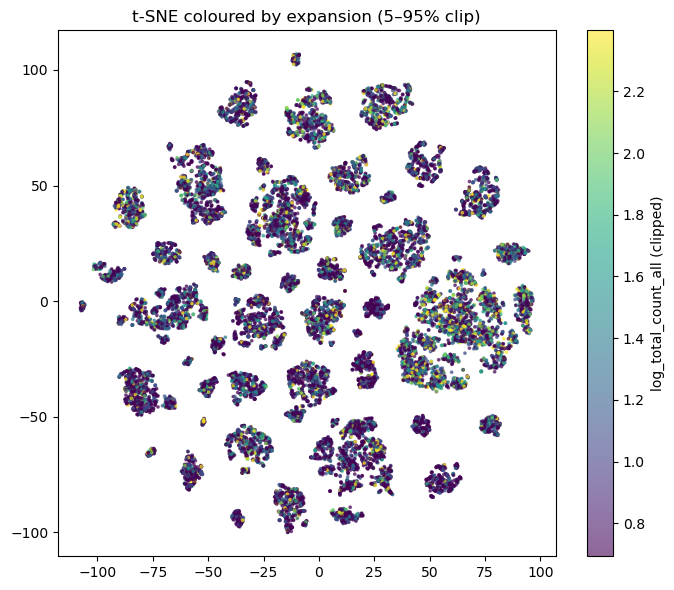

In [141]:
# coloured by expandsion 
# clip to 95% so it looks better

c_exp = clono_global["log_total_count_all"].values[idx]
c_exp = clono_subset["log_total_count_all"].values

vmin, vmax = np.quantile(c_exp, [0.05, 0.95])  # try 0.01/0.99 if needed

plt.figure(figsize=(7,6))
sc = plt.scatter(Z[:,0], Z[:,1], s=3, alpha=0.6, c=c_exp, vmin=vmin, vmax=vmax)
plt.colorbar(sc, label="log_total_count_all (clipped)")
plt.title("t-SNE coloured by expansion (5–95% clip)")
plt.tight_layout()
plt.show()


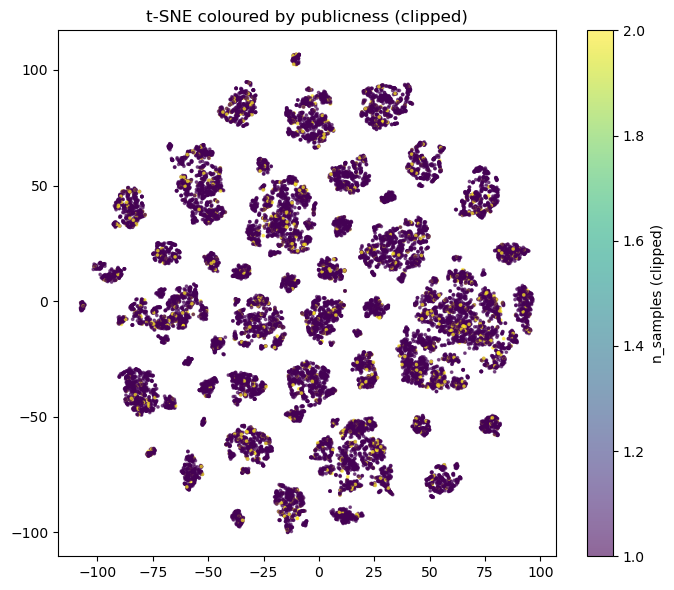

In [143]:
c_pub = clono_subset["n_samples"].values
vmin, vmax = np.quantile(c_pub, [0.05, 0.95])

plt.figure(figsize=(7,6))
sc = plt.scatter(Z[:,0], Z[:,1], s=3, alpha=0.6, c=c_pub, vmin=vmin, vmax=vmax)
plt.colorbar(sc, label="n_samples (clipped)")
plt.title("t-SNE coloured by publicness (clipped)")
plt.tight_layout()
plt.show()


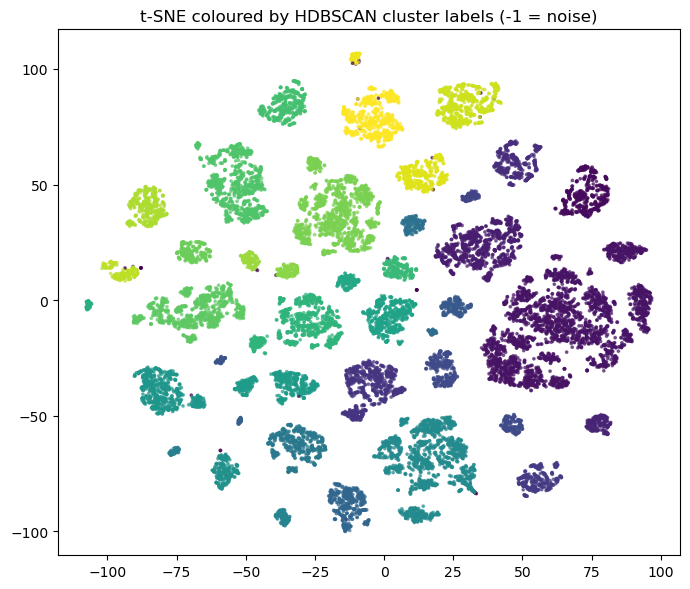

In [119]:
# hbscan clustering analysis

import hdbscan
import numpy as np

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric="euclidean"
)
labels = clusterer.fit_predict(X_pca)
np.unique(labels)[:10], (labels == -1).mean()


plt.figure(figsize=(7,6))
plt.scatter(Z[:,0], Z[:,1], s=3, alpha=0.6, c=labels)
plt.title("t-SNE coloured by HDBSCAN cluster labels (-1 = noise)")
plt.tight_layout()
plt.show()


#### Load Baseline Model Without Boltz

In [120]:
# need to define the ESMFactorisedEncoder class (new notebook with all these to import)
import torch
import torch.nn as nn

# Factorised Encoder to get z_T and Z_pMHC
# z = vec(A^TXB)H
# X - (B, L_pad, D)
# B - (D, rD)
# A - (L_pad, rL)
# H - (rD * rL, d)


eps = 1e-8

class ESMFactorisedEncoder(nn.Module):
    def __init__(self, D, rL, rD, d, L_max):
        """
        D    : ESM embedding dim (e.g. 960)
        rL   : positional rank
        rD   : channel rank
        d    : latent dim
        L_max: max true length for this modality in the batch
        """
        super().__init__()
        self.D   = D
        self.rL  = rL
        self.rD  = rD
        self.d   = d
        self.L_max = L_max

        # Channel mixing: D -> rD
        self.B_c = nn.Parameter(torch.empty(D, rD))
        nn.init.xavier_uniform_(self.B_c)

        # Positional mixing: positions 0..L_max-1 -> rL
        self.A_c = nn.Parameter(torch.empty(L_max, rL))
        nn.init.xavier_uniform_(self.A_c)

        # Final map: (rL * rD) -> d
        self.H_c = nn.Parameter(torch.empty(rL * rD, d))
        nn.init.xavier_uniform_(self.H_c)

    def forward(self, emb, mask):
        """
        emb  : (B, L_pad, D) token embeddings
        mask : (B, L_pad)   1 = real token, 0 = pad
        returns z : (B, d)
        """
        device = emb.device
        B, L_pad, D = emb.shape
        assert D == self.D

        # Compute true lengths
        L_true = mask.sum(dim=1)            # (B,)
        z_list = []

        for b in range(B):
            Lb = int(L_true[b].item())
            if Lb == 0:
                # Degenerate case: no tokens -> zero vector
                z_b = torch.zeros(self.d, device=device)
                z_list.append(z_b)
                continue

            Xb = emb[b, :Lb, :]                      # (Lb, D)
            mb = mask[b, :Lb].unsqueeze(-1).float()  # (Lb, 1)
            Xb = Xb * mb                             # (Lb, D)

            # 1) Channel compression: D -> rD
            Yb = Xb @ self.B_c                       # (Lb, rD)

            # 2) Positional compression: Lb -> rL
            A_pos = self.A_c[:Lb, :]                 # (Lb, rL)
            Ub = A_pos.T @ Yb                        # (rL, rD)

            # 3) Flatten and map to latent d
            Ub_flat = Ub.reshape(-1)                 # (rL * rD,)
            z_b = Ub_flat @ self.H_c                 # (d,)

            # 4) Normalise (optional; you can drop this if you want magnitude to carry info)
            #z_b = z_b / (z_b.norm() + eps)
            #normalise after function because need to combine p and hla first

            z_list.append(z_b)

        z = torch.stack(z_list, dim=0)               # (B, d)
        return z


In [93]:

BASE_DIR = Path("/home/natasha/multimodal_model")
checkpoints_dir = BASE_DIR / "models" / "checkpoints"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 1) Load checkpoint dict(s)
checkpoint_tcr = torch.load(checkpoints_dir / "tcr_encoder_checkpoint.pth", map_location="cpu")


# 2) Recreate LoRA cfg EXACTLY like training
lora_cfg = LoraConfig(
r=8, lora_alpha=32, lora_dropout=0.05, bias="none",
target_modules=["out_proj", "layernorm_qkv.1"],
)


# 3) Recreate model architecture + attach LoRA adapters
tcr_encoder = LoraModel(ESMC.from_pretrained("esmc_300m"), lora_cfg, adapter_name="tcr")


# 4) Load weights (base + LoRA)
tcr_encoder.load_state_dict(checkpoint_tcr["tcr_model_state_dict"], strict=True)


# 5) Inference mode
tcr_encoder.to(device).eval()


print("✓ TCR encoder loaded")

✓ TCR encoder loaded


In [101]:
import torch
from pathlib import Path

def load_tcr_factoriser(ckpt_path: Path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")

    cfg = ckpt["config"]
    rL = cfg["rL"]
    rD = cfg["rD"]
    d  = cfg["d"]
    L_max = cfg["L_T_max"]

    # Infer D from weight tensor
    D = ckpt["tcr_factorised"]["B_c"].shape[0]

    model = ESMFactorisedEncoder(D=D, rL=rL, rD=rD, d=d, L_max=L_max)
    model.load_state_dict(ckpt["tcr_factorised"], strict=True)
    model.to(device).eval()
    return model, cfg

ckpt_path = Path(checkpoints_dir) / "baseline_without_boltz" / "baseline_without_boltz" / "checkpoint_step_003500.pt"
factoriser, cfg = load_tcr_factoriser(ckpt_path, device)
print("✓ Loaded factoriser:", {k: cfg[k] for k in ["rL","rD","d","L_T_max"]})

✓ Loaded factoriser: {'rL': 8, 'rD': 16, 'd': 128, 'L_T_max': 249}


In [125]:
from torch.utils.data import Dataset, DataLoader
import torch

#tcrs_data = clono_global["sequence_aa"].astype(str).tolist()
tcrs_data = clono_subset["sequence_aa"].astype(str).tolist()

class SeqDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx]

def collate_clean(seqs):
    enc = tcr_encoder.model.tokenizer(  # or model.tokenizer if you named it "model"
        seqs,
        return_tensors="pt",
        padding=True,
        truncation=False,   # important: match your training behaviour
    )
    return {
        "clean_input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
    }

tcr_loader = DataLoader(
    SeqDataset(tcrs_data),
    batch_size=8,
    shuffle=False,
    drop_last=False,
    num_workers=4,
    collate_fn=collate_clean,
    pin_memory=True,
)

In [126]:
import gc
from pathlib import Path
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tcr_encoder.to(device).eval()
factoriser.to(device).eval()

z_dir = BASE_DIR / "embeddings" / "cancer_beta_zT"
z_dir.mkdir(parents=True, exist_ok=True)

chunk_size = 200
chunk = []
shard_id = 0

with torch.inference_mode():
    for i, batch in enumerate(tcr_loader):
        tcr_ids  = batch["clean_input_ids"].to(device, non_blocking=True)        # (B,L)
        tcr_mask = batch["attention_mask"].to(device, non_blocking=True).bool() # (B,L)

        # Safety: factoriser positional capacity
        max_Lb = int(tcr_mask.sum(dim=1).max().item())
        if max_Lb > factoriser.L_max:
            raise ValueError(f"Found length {max_Lb} > factoriser.L_max={factoriser.L_max}")

        # ESMC token embeddings
        out = tcr_encoder.model(sequence_tokens=tcr_ids)
        emb_T = out.embeddings  # (B,L,D)

        # Factorised representation
        z_T = factoriser(emb_T, tcr_mask)  # (B,d)

        chunk.append({"z_T": z_T.to(torch.float16).cpu()})

        # cleanup
        del tcr_ids, tcr_mask, out, emb_T, z_T
        if torch.cuda.is_available() and (i % 50 == 0):
            torch.cuda.empty_cache()

        if len(chunk) >= chunk_size:
            torch.save(chunk, z_dir / f"zT_shard_{shard_id:05d}.pt")
            shard_id += 1
            chunk.clear()
            gc.collect()

if chunk:
    torch.save(chunk, z_dir / f"zT_shard_{shard_id:05d}.pt")
    chunk.clear()
    gc.collect()

print(f"✓ Saved z_T shards to {z_dir}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

✓ Saved z_T shards to /home/natasha/multimodal_model/embeddings/cancer_beta_zT


Z_all: (20000, 128)
Z_sub: (20000, 128)


/home/natasha/miniconda3/envs/tcr-multimodal/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


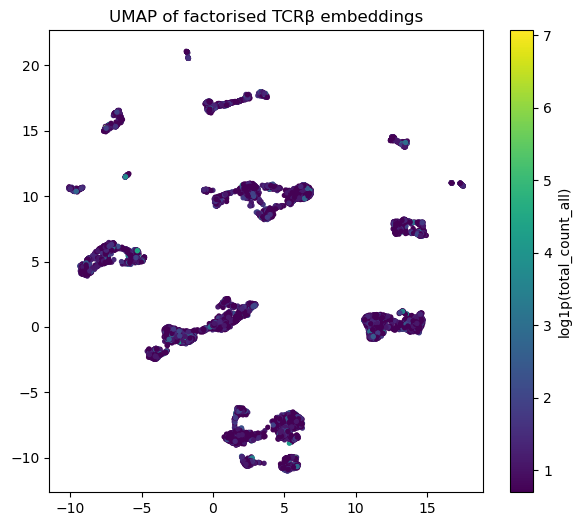

In [132]:
# load zT and run PCA for UMAP/tsne plotting

import torch
import numpy as np
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

def load_zT(z_dir):
    Z = []
    for sp in sorted(Path(z_dir).glob("zT_shard_*.pt")):
        chunk = torch.load(sp, map_location="cpu")
        for item in chunk:
            Z.append(item["z_T"])
    return torch.cat(Z, dim=0).numpy()

Z_all = load_zT(z_dir)
print("Z_all:", Z_all.shape)

# # subsample for plotting
# N = Z_all.shape[0]
# rng = np.random.default_rng(42)
# idx = rng.choice(N, size=min(20000, N), replace=False)

#Z_sub = Z_all[idx]
Z_sub = Z_all
print('Z_sub:', Z_sub.shape)
Z_sub_pca = PCA(n_components=min(50, Z_sub.shape[1]), random_state=42).fit_transform(Z_sub)

Y = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42).fit_transform(Z_sub_pca)

c = clono_global.loc[idx, "log_total_count_all"].to_numpy()

plt.figure(figsize=(7,6))
plt.scatter(Y[:,0], Y[:,1], s=8, c=c)
plt.colorbar(label="log1p(total_count_all)")
plt.title("UMAP of factorised TCRβ embeddings")
plt.show()

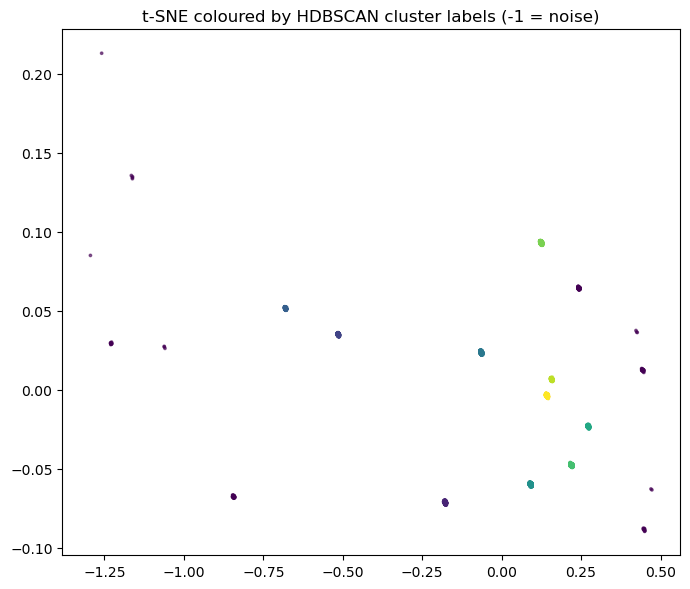

In [147]:
# hbscan clustering analysis

import hdbscan
import numpy as np

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=10,
    metric="euclidean"
)
labels = clusterer.fit_predict(Z_sub_pca)
np.unique(labels)[:10], (labels == -1).mean()


plt.figure(figsize=(7,6))
plt.scatter(Z_sub_pca[:,0], Z_sub_pca[:,1], s=3, alpha=0.6, c=labels)
plt.title("t-SNE coloured by HDBSCAN cluster labels (-1 = noise)")
plt.tight_layout()
plt.show()


Clustering Analysis - Is fine-tuned model better than ESMC at local enrichment?

In [ ]:
# Define kNN neighbourhoods in embedding space
# For each clonotype i, define its neighbourhood and its k nearest neighbours in the embedding space
# Compute the local variance of expansion or all points and all expanded points in the neighbourhood

# Expanded points should sit in neighbourhoods where expansion is more homogeneous
# Therefore baseline model should have lower variance relative to ESM baseline

In [ ]:
# check the dimensions are the same

print(X_sub.shape, Z_sub.shape)
# checks number of samples (rows) are the same
assert X_sub.shape[0] == Z_sub.shape[0]


(20000, 960) (20000, 128)


In [134]:
# get the expansion value to compare across ESM model and baseline model
exp_sub = clono_subset["log_total_count_all"].to_numpy(dtype=np.float32)


In [136]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

def knn_local_stats(emb, exp, *, k=30, pca_dim=30, seed=42):
    """
    emb: (n, d) embedding matrix
    exp: (n,) expansion signal (float)
    Returns:
      local_mean: (n,)
      local_var:  (n,)
    """
    emb = np.asarray(emb, dtype=np.float32)
    exp = np.asarray(exp, dtype=np.float32)

    # PCA purely for speed/stability of kNN in high-D
    pca_dim = min(pca_dim, emb.shape[1])
    emb_p = PCA(n_components=pca_dim, svd_solver="randomized", random_state=seed).fit_transform(emb).astype(np.float32)

    nn = NearestNeighbors(n_neighbors=k+1, n_jobs=-1)
    nn.fit(emb_p)
    nbr_idx = nn.kneighbors(emb_p, return_distance=False)[:, 1:]  # drop self

    nbr_exp = exp[nbr_idx]             # (n, k)
    local_mean = nbr_exp.mean(axis=1)  # (n,)
    local_var  = nbr_exp.var(axis=1)   # (n,)
    return local_mean, local_var


In [139]:
ks = [5, 10, 20, 30, 50, 100]
for k in ks:
    mean_esm, var_esm = knn_local_stats(X_sub, exp_sub, k=k, pca_dim=50)
    mean_ft,  var_ft  = knn_local_stats(Z_sub, exp_sub, k=k, pca_dim=30)

    corr_esm = float(np.corrcoef(exp_sub, mean_esm)[0,1])
    corr_ft  = float(np.corrcoef(exp_sub, mean_ft)[0,1])

    print(f"k={k:3d} | corr ESM={corr_esm:.3f} FT={corr_ft:.3f} | var ESM={var_esm.mean():.3f} FT={var_ft.mean():.3f}")


k=  5 | corr ESM=0.079 FT=0.053 | var ESM=0.325 FT=0.320
k= 10 | corr ESM=0.105 FT=0.068 | var ESM=0.361 FT=0.361
k= 20 | corr ESM=0.130 FT=0.089 | var ESM=0.377 FT=0.382
k= 30 | corr ESM=0.147 FT=0.096 | var ESM=0.384 FT=0.389
k= 50 | corr ESM=0.157 FT=0.110 | var ESM=0.392 FT=0.395
k=100 | corr ESM=0.170 FT=0.117 | var ESM=0.396 FT=0.397


In [148]:
lens = clono_subset["sequence_aa"].astype(str).str.len().to_numpy()

def neigh_stat_from_idx(nbr_idx, values):
    return values[nbr_idx].mean(axis=1), values[nbr_idx].var(axis=1)

# reuse nbr_idx from each run by modifying knn_local_stats to return nbr_idx


In [ ]:
# don't understand this - need to write some notes

thr = np.quantile(exp_sub, 0.90)  # top 10%
y = (exp_sub >= thr).astype(np.int32)

def knn_neighbour_label_fraction(emb, y, *, k=30, pca_dim=30):
    emb = np.asarray(emb, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    emb_p = PCA(n_components=min(pca_dim, emb.shape[1]), svd_solver="randomized", random_state=42).fit_transform(emb)
    nn = NearestNeighbors(n_neighbors=k+1, n_jobs=-1).fit(emb_p)
    idx = nn.kneighbors(emb_p, return_distance=False)[:, 1:]
    return y[idx].mean(axis=1)

frac_esm = knn_neighbour_label_fraction(X_sub, y, k=30, pca_dim=50)
frac_ft  = knn_neighbour_label_fraction(Z_sub, y, k=30, pca_dim=30)

print("Expanded points: mean expanded-neighbour fraction")
print("ESM:", float(frac_esm[y==1].mean()))
print("FT :", float(frac_ft[y==1].mean()))


Expanded points: mean expanded-neighbour fraction
ESM: 0.13121378421783447
FT : 0.12124122679233551


In [ ]:
# length homogeneity - not sure if this is really a good metric to test?
# The metric below is length variance

lens = clono_subset["sequence_aa"].astype(str).str.len().to_numpy()

def knn_indices(emb, *, k=30, pca_dim=30):
    emb = np.asarray(emb, dtype=np.float32)
    emb_p = PCA(
        n_components=min(pca_dim, emb.shape[1]),
        svd_solver="randomized",
        random_state=42
    ).fit_transform(emb)

    nn = NearestNeighbors(n_neighbors=k+1, n_jobs=-1).fit(emb_p)
    return nn.kneighbors(emb_p, return_distance=False)[:, 1:]


nbr_esm = knn_indices(X_sub, k=30, pca_dim=50)
nbr_ft  = knn_indices(Z_sub, k=30, pca_dim=30)

def neigh_stat_from_idx(nbr_idx, values):
    return values[nbr_idx].mean(axis=1), values[nbr_idx].var(axis=1)


mean_len_esm, var_len_esm = neigh_stat_from_idx(nbr_esm, lens)
mean_len_ft,  var_len_ft  = neigh_stat_from_idx(nbr_ft, lens)


print("Mean neighbour length variance")
print("ESM:", float(var_len_esm.mean()))
print("FT :", float(var_len_ft.mean()))


Mean neighbour length variance
ESM: 0.8094545
FT : 0.0025701111111111107


In [ ]:
import numpy as np

def kmers(s, k=3):
    return {s[i:i+k] for i in range(len(s)-k+1)} if len(s) >= k else {s}

def mean_neighbour_kmer_jaccard(seqs, nbr_idx, k=3, n_eval=2000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(seqs)
    eval_idx = rng.choice(n, size=min(n_eval, n), replace=False)

    # precompute kmer sets for evaluated points + their neighbours
    ksets = [kmers(seqs[i], k) for i in range(n)]  # if n=20k, ok; if too slow, we can memoise only eval+neigh

    sims = []
    for i in eval_idx:
        A = ksets[i]
        for j in nbr_idx[i]:
            B = ksets[j]
            sims.append(len(A & B) / max(1, len(A | B)))
    return float(np.mean(sims))

seqs = clono_subset["sequence_aa"].astype(str).to_numpy()

jac_esm = mean_neighbour_kmer_jaccard(seqs, nbr_esm, k=3, n_eval=2000)
jac_ft  = mean_neighbour_kmer_jaccard(seqs, nbr_ft,  k=3, n_eval=2000)

print("Mean neighbour 3-mer Jaccard:")
print("ESM:", jac_esm)
print("FT :", jac_ft)


Mean neighbour 3-mer Jaccard:
ESM: 0.83456774157931
FT : 0.44522664747278645
